In [ ]:
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

DATA_DIR = 'assets_train'
NUM_FILES = 120000

def extract_lemmas(file_path):
    try:
        df = pd.read_csv(file_path, sep='\t', header=None, names=['token', 'stem', 'lemma'])
        df = df.dropna()
        lemmas = ' '.join(df['lemma'].astype(str).tolist())
        return lemmas
    except Exception as e:
        print(f"Ошибка при чтении {file_path}: {e}")
        return ''

documents = []
for i in range(1, NUM_FILES + 1):
    file_path = os.path.join(DATA_DIR, f'{i}.tsv')
    lemmas = extract_lemmas(file_path)
    if lemmas:
        documents.append(lemmas)

vectorizer = CountVectorizer(min_df=5, max_df=0.95, token_pattern=r'(?u)\b[a-z][a-z][a-z]+\b', stop_words='english')
train_matrix = vectorizer.fit_transform(documents)

terms = vectorizer.get_feature_names_out()
doc_names = [f'{i}.tsv' for i in range(1, NUM_FILES + 1)]

In [3]:
TEST_DIR = 'assets'
TEST_NUM_FILES = 7600

test_docs = []
test_filenames = []

for i in range(1, TEST_NUM_FILES + 1):
    file_path = os.path.join(TEST_DIR, f'{i}.tsv')
    lemmas = extract_lemmas(file_path)
    if lemmas:
        test_docs.append(lemmas)
        test_filenames.append(f'{i}.tsv')

test_matrix = vectorizer.transform(test_docs)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
import warnings
warnings.filterwarnings('ignore')

n_topics_list = [2, 3, 4, 5, 10, 20, 40]
results = {}

for n_topics in n_topics_list:
    print(f"Эксперимент с {n_topics} темами")
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        learning_method='online',
        learning_offset=50,
        random_state=42
    )
    
    lda.fit(train_matrix)
    
    perplexity = lda.perplexity(test_matrix)
    print(f"Perplexity на тестовой выборке: {perplexity:.2f}")
    
    print("Топ-10 ключевых слов для каждой темы:")
    
    topic_keywords = {}
    feature_names = terms
    
    for topic_idx, topic in enumerate(lda.components_):
        top_features_ind = topic.argsort()[:-11:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topic_keywords[topic_idx] = top_features
        
        print(f"\nТема #{topic_idx + 1}:")
        print(", ".join(top_features))
    
    doc_topic_dist = lda.transform(train_matrix)
    test_doc_topic_dist = lda.transform(test_matrix)
    
    results[n_topics] = {
        'model': lda,
        'perplexity': perplexity,
        'topic_keywords': topic_keywords,
        'train_doc_topic_dist': doc_topic_dist,
        'test_doc_topic_dist': test_doc_topic_dist
    }
    
    df_train_topics = pd.DataFrame(
        doc_topic_dist,
        columns=[f'Тема_{i+1}' for i in range(n_topics)]
    )
    df_train_topics['document'] = [doc_names[i] if i < len(doc_names) else f"doc_{i}" 
                                   for i in range(len(doc_topic_dist))]
    df_train_topics.to_csv(f'train_doc_topic_distribution_{n_topics}_topics.csv', index=False)
    
    df_test_topics = pd.DataFrame(
        test_doc_topic_dist,
        columns=[f'Тема_{i+1}' for i in range(n_topics)]
    )
    df_test_topics.to_csv(f'test_doc_topic_distribution_{n_topics}_topics.csv', index=False)
    

Эксперимент с 2 темами
Perplexity на тестовой выборке: 6180.19
Топ-10 ключевых слов для каждой темы:

Тема #1:
said, year, game, quot, new, president, reuters, sunday, state, season

Тема #2:
new, said, reuters, company, year, corp, million, stock, oil, price
Эксперимент с 3 темами
Perplexity на тестовой выборке: 6803.10
Топ-10 ключевых слов для каждой темы:

Тема #1:
said, year, game, sunday, new, season, team, night, reuters, saturday

Тема #2:
said, reuters, new, company, year, stock, oil, price, york, million

Тема #3:
new, quot, service, company, microsoft, software, internet, computer, year, technology
Эксперимент с 4 темами
Perplexity на тестовой выборке: 7186.50
Топ-10 ключевых слов для каждой темы:

Тема #1:
team, quot, world, year, final, second, time, won, cup, champion

Тема #2:
new, company, said, reuters, year, corp, stock, oil, million, price

Тема #3:
game, new, fullquote, season, reuters, night, york, ticker, http, year

Тема #4:
said, president, reuters, official, ira

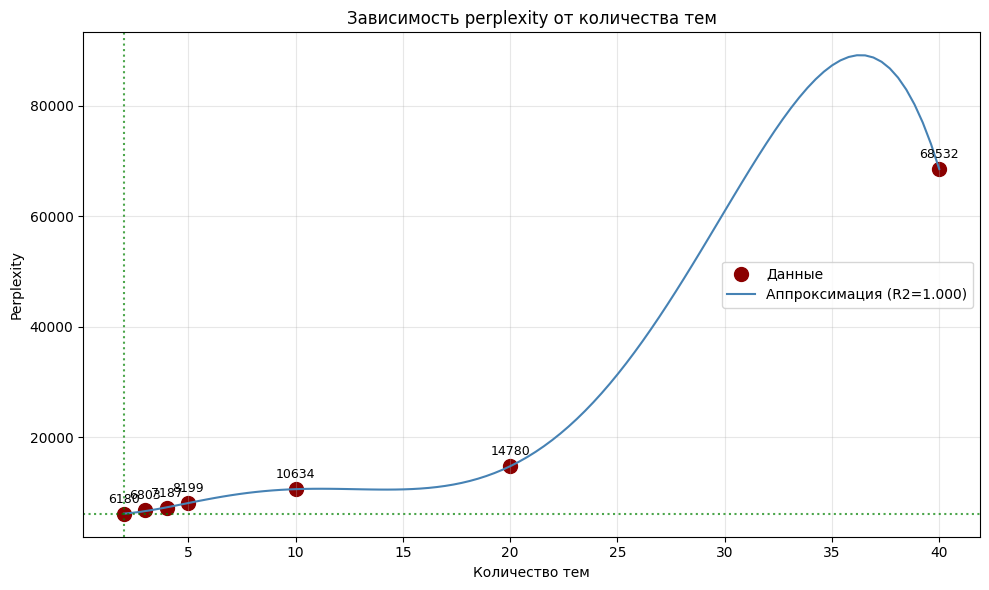

Оптимальная степень: 5 (R2=1.0000)
Оптимум по темам: 2, perplexity=6180.2


In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from numpy.polynomial.polynomial import Polynomial

n_topics_list = sorted(results.keys())
perplexities = [results[n]['perplexity'] for n in n_topics_list]

X, y = np.array(n_topics_list).reshape(-1, 1), np.array(perplexities)
best_degree, best_r2 = 1, -np.inf

for degree in range(1, min(5, len(n_topics_list)-1)+1):
    X_poly = PolynomialFeatures(degree).fit_transform(X)
    model = LinearRegression().fit(X_poly, y)
    r2 = r2_score(y, model.predict(X_poly))
    if r2 > best_r2:
        best_degree, best_r2 = degree, r2

poly = PolynomialFeatures(best_degree)
X_poly = poly.fit_transform(X)
model = LinearRegression().fit(X_poly, y)

X_smooth = np.linspace(min(n_topics_list), max(n_topics_list), 100).reshape(-1, 1)
y_smooth = model.predict(poly.transform(X_smooth))

plt.figure(figsize=(10, 6))
plt.scatter(n_topics_list, perplexities, s=100, color='darkred', label='Данные')
plt.plot(X_smooth, y_smooth, 'steelblue', label=f'Аппроксимация (R2={best_r2:.3f})')

opt_idx = np.argmin(perplexities)
plt.axvline(x=n_topics_list[opt_idx], color='green', linestyle=':', alpha=0.7)
plt.axhline(y=perplexities[opt_idx], color='green', linestyle=':', alpha=0.7)

for x, y_val in zip(n_topics_list, perplexities):
    plt.annotate(f'{y_val:.0f}', (x, y_val), xytext=(0, 8), 
                 textcoords='offset points', ha='center', fontsize=9)

plt.xlabel('Количество тем'); plt.ylabel('Perplexity')
plt.title('Зависимость perplexity от количества тем')
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.savefig('perplexity.png', dpi=120); plt.show()

print(f"Оптимальная степень: {best_degree} (R2={best_r2:.4f})")
print(f"Оптимум по темам: {n_topics_list[opt_idx]}, perplexity={perplexities[opt_idx]:.1f}")